In [1]:
import ipytest
ipytest.autoconfig()

import weakref

import numpy as np
import pytest
import xarray as xr
from xarray import DataArray
import pandas as pd

from climate_index_collection.reductions import (
    grouped_mean_weighted,
    monthly_mean_weighted,
    monthly_mean_unweighted,
    monthly_anomalies_unweighted,
    monthly_anomalies_weighted,
)
from climate_index_collection.data_loading import load_data_set

In [2]:
CESM_DATA = load_data_set(data_path="../data/test_data/", data_source_name="CESM")
FOCI_DATA = load_data_set(data_path="../data/test_data/", data_source_name="FOCI")


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [3]:
# ========
# CREATE TEST DATA PARAMETERS AND FUNCTIONS
# ========

lon = np.array([120,140,150])
lat = np.array([-10, -5, 0])

def create_data_array(values,  dim, dim_name) :
    """
    This function creates test DataArrays from given lat, lon, group and groupname and weights.
    -----
    Parameters:
        lat: numpy.adarray, list
        lon: numpy.adarray, list
        values: numpy.adarray
        group: numpy.adarray, list
        groupname: str
    """
    # create dummy dataset 
    data = DataArray(values, 
                     dims=(dim_name, 
                           "lat", 
                           "lon"), 
                     coords={dim_name : dim, 
                             "lat": lat, 
                             'lon': lon})
    return data

def create_weight_array(wei, dim, dim_name) :    
    weights = DataArray(wei, 
                        dims=(dim_name), 
                        coords={dim_name : dim})
    return weights 

def create_mean_array(mean, group_unique, group_name) :    
    weights = DataArray(mean, 
                 dims=(group_name, "lat", "lon"), 
                 coords={group_name : group_unique, "lat": lat, 'lon': lon})
    return weights 

In [4]:
# ----------
# First test DataArray
weights_1 = [1, 2, 3, 2]
dim_1 = ['a','b','a','c']
dim_name_1 = group_name_1 = "group" 
group_unique_1 = np.unique(dim_1)

np.random.seed(100)
values_1 = np.random.randint(0,2, (len(dim_1), len(lat), len(lon)) ).astype(float)
values_1[0,0,0] = np.nan
data_1 = create_data_array(values = values_1, 
                            dim = dim_1,
                            dim_name = dim_name_1)
weights_1 = create_weight_array(wei = weights_1,
                                dim = dim_1,
                                dim_name = dim_name_1)


# Should be the correct values
weighted_mean_1 = np.array(
      [[[0.  , 0.75, 0.25],
        [1.  , 0.25, 0.25],
        [0.  , 0.75, 0.75]],

       [[0.  , 0.  , 1.  ],
        [0.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  ]],

       [[1.  , 0.  , 0.  ],
        [1.  , 0.  , 0.  ],
        [1.  , 1.  , 1.  ]]])

weighted_mean_should_1 = create_mean_array(mean = weighted_mean_1,
                                        group_unique = group_unique_1,
                                        group_name = group_name_1)

In [5]:
# ----------
# Second test DataArray
dim_2 = pd.to_datetime(["2020-02-13", "2021-06-13", "2021-08-13", "2022-02-13"])
dim_name_2 = "time"
weights_2 = dim_2.days_in_month
group_unique_2 = np.unique(dim_2.month)
group_name_2 = "month"
values_2 = np.array(
      [[[np.nan,  0., 57.],
        [57., 57., 57.],
        [ 0.,  0.,  57.]],

       [[ 0.,  0., 57.],
        [ 0.,  0.,  0.],
        [ 0., 57.,  0.]],

       [[ 0., 57.,  0.],
        [57.,  0.,  0.],
        [ 0., 57., 57.]],

       [[57.,  0.,  0.],
        [57.,  0.,  0.],
        [57., 57., 57.]]])


data_2 = create_data_array(values = values_2, 
                           dim = dim_2, 
                           dim_name=dim_name_2)

weighted_mean_2 = np.array(
      [[[57.,  0., 29.],
        [57., 29., 29.],
        [28., 28., 57.]],

       [[ 0.,  0., 57.],
        [ 0.,  0.,  0.],
        [ 0., 57.,  0.]],

       [[ 0., 57.,  0.],
        [57.,  0.,  0.],
        [ 0., 57., 57.]]])

unweighted_mean_2 = np.array(
      [[[57,  0., 28.5,],
        [57, 28.5, 28.5,],
        [28.5, 28.5,  57]],

       [[ 0.,  0., 57.],
        [ 0.,  0.,  0.],
        [ 0., 57.,  0.]],

       [[ 0., 57.,  0.],
        [57.,  0.,  0.],
        [ 0., 57., 57.]]])

weighted_mean_should_2 = create_mean_array(mean = weighted_mean_2,
                                        group_unique=group_unique_2,
                                        group_name = group_name_2)
unweighted_mean_should_2 = create_mean_array(mean = unweighted_mean_2,
                                        group_unique=group_unique_2,
                                        group_name = group_name_2)

weights_2 =  create_weight_array(wei = weights_2, 
                                  dim = dim_2, 
                                  dim_name=dim_name_2)
# aslo create a dataset
dataset_2 = data_2.to_dataset(dim=None, name="test", promote_attrs=False)

In [6]:
# calculate the monthly anomalies for the data now nans will be included!
anomalies_weighted_2 = np.array([
    values_2[0] - weighted_mean_should_2[0],
    values_2[1] - weighted_mean_should_2[1],
    values_2[2] - weighted_mean_should_2[2],
    values_2[3] - weighted_mean_should_2[0],
    ])
anomalies_weighted_2 = create_data_array(values = anomalies_weighted_2, 
                                  dim = dim_2, 
                                  dim_name=dim_name_2)

anomalies_unweighted_2 = np.array([
    values_2[0] - unweighted_mean_should_2[0],
    values_2[1] - unweighted_mean_should_2[1],
    values_2[2] - unweighted_mean_should_2[2],
    values_2[3] - unweighted_mean_should_2[0],
    ])
anomalies_unweighted_2 = create_data_array(values = anomalies_unweighted_2, 
                                  dim = dim_2, 
                                  dim_name=dim_name_2)

In [7]:
@pytest.mark.parametrize("data, weights, dim     , groupby_dim, should",[ 
    (data_1, weights_1, group_name_1 , group_name_1 , weighted_mean_should_1),
    (data_2, weights_2, "time" , "time.month" , weighted_mean_should_2),
                         ])
def test_grouped_mean_weighted(data, weights, dim, groupby_dim, should):
    """Checks if the groupby weighting function gives proper results."""
    result = grouped_mean_weighted(dobj=data, weights= weights, dim = dim, groupby_dim= groupby_dim)
    assert result.equals(should)

@pytest.mark.parametrize("data_set, name, should",[ 
        (dataset_2, "test", weighted_mean_should_2),
])
def test_monthly_mean_weighted(data_set, name, should):
    """Checks if the monthly mean weighted function gives proper results."""
    result = monthly_mean_weighted(dobj=data_set)
    assert result[name].equals(should)

@pytest.mark.parametrize("data_set, name, should",[ 
        (dataset_2, "test", unweighted_mean_should_2),
])
def test_monthly_mean_unweighted(data_set, name, should):
    """Checks if the monthly mean unweighted function gives proper results."""
    result = monthly_mean_unweighted(dobj=data_set)
    assert result[name].equals(should)

# Tests for anomaly functions
# check if the results are correct
@pytest.mark.parametrize("data_set, name, should",[ 
        (dataset_2, "test", anomalies_weighted_2),
])
def test_monthly_anomalies_weighted(data_set, name, should):
    """Checks if the monthly anomalies weighted function gives proper results."""
    result = monthly_anomalies_weighted(dobj=data_set)
    assert result[name].equals(should)

@pytest.mark.parametrize("data_set, name, should",[ 
        (dataset_2, "test", anomalies_unweighted_2),
])
def test_monthly_anomalies_unweighted(data_set, name, should):
    """Checks if the monthly anomalies unweighted function gives proper results."""
    result = monthly_anomalies_unweighted(dobj=data_set)
    assert result[name].equals(should)

    

In [132]:
# # Check if the mean of the anomalies is 0

@pytest.mark.parametrize("data_set",[ 
        (dataset_2["test"]),
        (FOCI_DATA["sea-surface-temperature"]),
        (FOCI_DATA["sea-level-pressure"]),
        (FOCI_DATA["geopotential-height"]),
        (CESM_DATA["sea-surface-temperature"]),
        (CESM_DATA["sea-level-pressure"]),
        (CESM_DATA["geopotential-height"]),
])
def test_ifmeanis0_monthly_anomalies_unweighted(data_set, rtol = 1e-6):
    """Checks if the mean of the anomalies are all close to 0 using numpy.allclose()
    rtol : float 
        relative accuracy Default of 1e-6.
    
    Absolute accuracy is calculated with (max(data_set) - min(data_set)) * rtol
    For further information look at numpy.allclose()
    From numpy:
    "The tolerance values are positive, typically very small numbers. 
    The relative difference (rtol * abs(b)) and the absolute difference atol are added together 
    to compare against the absolute difference between a and b."
    """
    result = monthly_anomalies_unweighted(dobj=data_set)
    # to calculate the absolute tolerance, we use :
    # ( max(data_set) - min(data_set) ) * rtol
    min_value = data_set.min().values
    max_value = data_set.max().values
    atol = (max_value-min_value)*rtol
    result_mean = result.mean("time")
    assert np.allclose(result_mean*0, result_mean,
                rtol = rtol,
                atol = atol,
                equal_nan = True)

# # Check if the mean of the anomalies is 0

@pytest.mark.parametrize("data_set",[ 
        #(dataset_2["test"]),   This does not work properly !!!
        (FOCI_DATA["sea-surface-temperature"]),
        (FOCI_DATA["sea-level-pressure"]),
        (FOCI_DATA["geopotential-height"]),
        (CESM_DATA["sea-surface-temperature"]),
        (CESM_DATA["sea-level-pressure"]),
        (CESM_DATA["geopotential-height"]),
])
def test_ifmeanis0_monthly_anomalies_weighted(data_set, rtol = 1e-3):
    """Checks if the mean of the anomalies are all close to 0 using numpy.allclose()
    rtol : float 
        relative accuracy Default of 1e-6.
    
    Absolute accuracy is calculated with (max(data_set) - min(data_set)) * rtol
    For further information look at numpy.allclose()
    From numpy:
    "The tolerance values are positive, typically very small numbers. 
    The relative difference (rtol * abs(b)) and the absolute difference atol are added together 
    to compare against the absolute difference between a and b."
    """
    result = monthly_anomalies_weighted(dobj=data_set)
    # to calculate the absolute tolerance, we use :
    # ( max(data_set) - min(data_set) ) * rtol
    min_value = data_set.min().values
    max_value = data_set.max().values
    atol = (max_value-min_value)*rtol
    result_mean = result.mean("time")
    assert np.allclose(result_mean*0, result_mean,
                rtol = rtol,
                atol = atol,
                equal_nan = True)


In [133]:
ipytest.run()

======================================= test session starts ========================================
platform linux -- Python 3.9.12, pytest-7.1.2, pluggy-1.0.0
rootdir: /work, configfile: pyproject.toml
plugins: anyio-3.5.0
collected 19 items

tmp4c_g8tsp.py ...................                                                           [100%]

========================================= warnings summary =========================================
notebooks/tmp4c_g8tsp.py: 12 warnings
  /srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
    return self.array[key]

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html
================================= 19 passed, 12 warnings in 15.15s =================================


<ExitCode.OK: 0>

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


271.14648 306.5498 3.54033203125e-05 1e-06
True


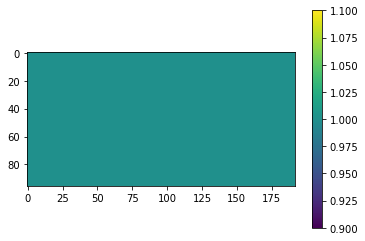

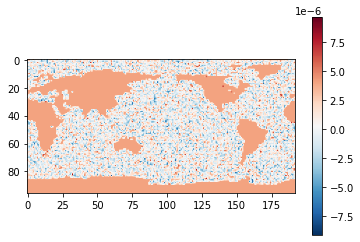

In [131]:
rtol = 1e-6
result = monthly_anomalies_unweighted(dobj=(FOCI_DATA["sea-surface-temperature"]))
# to calculate the absolute tolerance, we use :
# ( max(data_set) - min(data_set) ) * rtol
min_value = (FOCI_DATA["sea-surface-temperature"]).min().values
max_value = (FOCI_DATA["sea-surface-temperature"]).max().values
atol = (  max_value - min_value ) * rtol
print(min_value, max_value, atol, rtol)
result_mean = result.mean("time")
# check if the results are equall to zero with an accuracy
print(np.allclose(result_mean*0, result_mean,
                rtol = rtol,
                atol = atol))
plt.imshow(np.isclose(result_mean*0, result_mean,
                rtol = rtol,
                atol = atol))
plt.colorbar()
plt.figure()
plt.imshow(result_mean, cmap = "RdBu_r")
plt.colorbar()

0.001 0.057


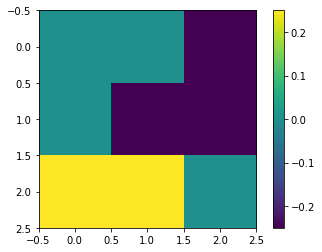

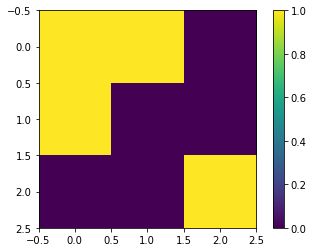

In [134]:
rtol = 1e-3
data_set = dataset_2["test"]
"""Checks if the mean of the anomalies are all close to 0 using numpy.allclose()
rtol : float 
    relative accuracy Default of 1e-6.

Absolute accuracy is calculated with (max(data_set) - min(data_set)) * rtol
For further information look at numpy.allclose()
From numpy:
"The tolerance values are positive, typically very small numbers. 
The relative difference (rtol * abs(b)) and the absolute difference atol are added together 
to compare against the absolute difference between a and b."
"""
result = monthly_anomalies_weighted(dobj=data_set)
# to calculate the absolute tolerance, we use :
# ( max(data_set) - min(data_set) ) * rtol
min_value = data_set.min().values
max_value = data_set.max().values
atol = (max_value-min_value)*rtol
print(rtol, atol)
result_mean = result.mean("time")
plt.figure()
plt.imshow(result_mean)
plt.colorbar()
plt.figure()
plt.imshow(np.isclose(result_mean*0, result_mean,
            rtol = rtol,
            atol = atol,
            equal_nan = True))
plt.colorbar()